In [1]:
from pref_voting.profiles_with_ties import *
from pref_voting.voting_methods import *
from pref_voting.analysis import *
from pref_voting.generate_profiles import *
from pref_voting.generate_weighted_majority_graphs import *

from pref_voting.utility_profiles import UtilityProfile, write_utility_profiles_to_json, read_utility_profiles_from_json
from pref_voting.rankings import Ranking
from pref_voting.generate_utility_profiles import *
from pref_voting.generate_utility_profiles import *
from pref_voting.utility_methods import *

from pref_voting.spatial_profiles import SpatialProfile
from pref_voting.generate_spatial_profiles import *
from pref_voting.utility_functions import *
from pref_voting.probabilistic_methods import *
from tqdm.notebook import tqdm
import nashpy as nash
import numpy as np
import random2 as random
from pref_voting.mappings import _Mapping
from multiprocess import Pool, cpu_count, current_process
from numba import njit, float32
import pickle
import json
from pref_voting.monotonicity_axioms import *
from pref_voting.helper import *
from pref_voting.variable_candidate_axioms import *
from pref_voting.grade_methods import *
from pref_voting.mappings import *
from pref_voting.io.writers import *

In [4]:
@vm(name="Split Cycle")
def split_cycle2(edata, curr_cands = None, strength_function = None):

    strength_matrix, cand_to_cindex = edata.strength_matrix(curr_cands = curr_cands, strength_function=strength_function)

    candidates = edata.candidates if curr_cands is None else curr_cands  

    strength_function = edata.margin if strength_function is None else strength_function 

    potential_winners = set(candidates)

    for a in candidates:
        for b in candidates:
            print("strength_function(b, a)", strength_function(b, a))
            print("strength_function(a, b)", strength_function(a, b))
            print(has_strong_path(strength_matrix, cand_to_cindex(a), cand_to_cindex(b), strength_function(b,a)))
            if strength_function(b, a) > strength_function(a, b) and not has_strong_path(strength_matrix, cand_to_cindex(a), cand_to_cindex(b), strength_function(b,a)):
                potential_winners.discard(a)
                break

    return sorted(potential_winners)



+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 2 | 0 | 2 | 1 |
| 1 |   |   |   | 0 |
| 2 |   |   |   |   |
+---+---+---+---+---+


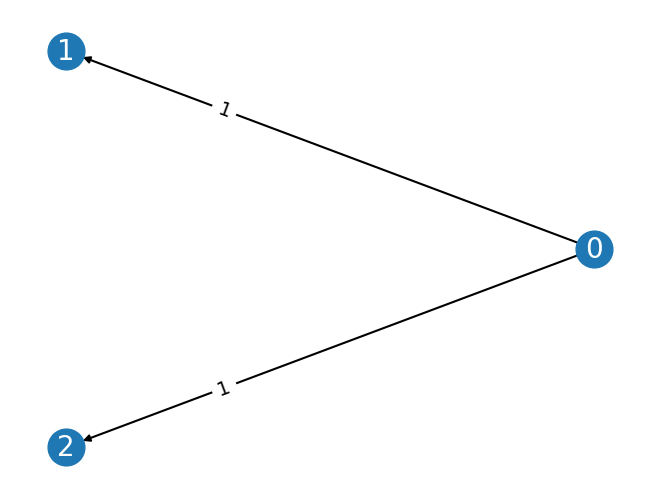

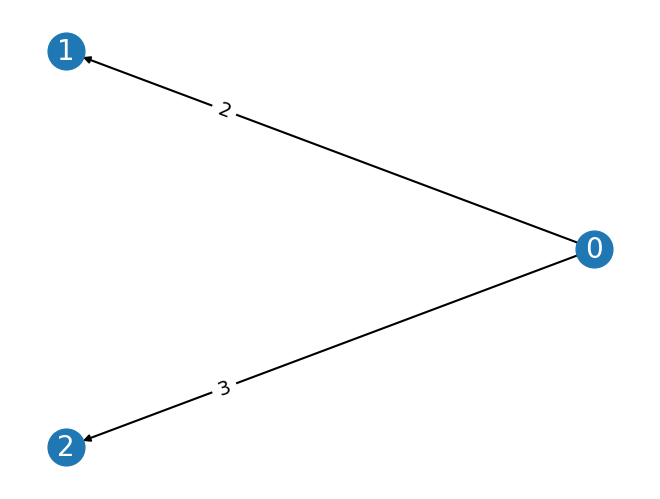

[[ 0  1  1]
 [-1  0  0]
 [-1  0  0]]
NOW SUPPORT
[[0 2 3]
 [1 0 2]
 [2 2 0]]
sc_ws [0]
sc_ws_support [0, 1]
sc fw [0]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 1 | 2 | 2 | 1 |
| 1 | 0 |   |   |   |
| 2 |   |   |   |   |
+---+---+---+---+---+


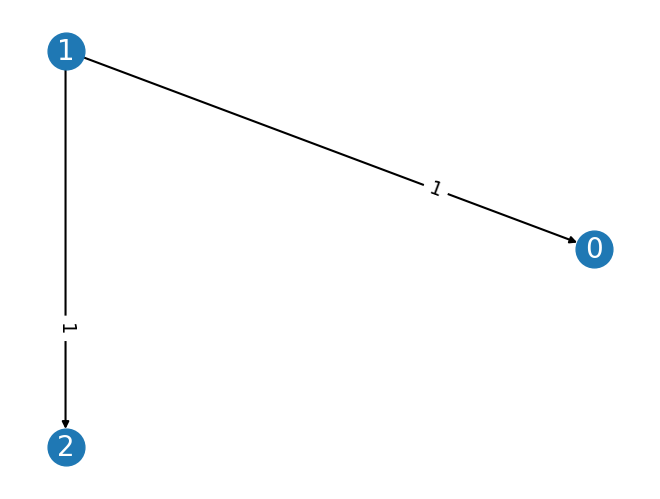

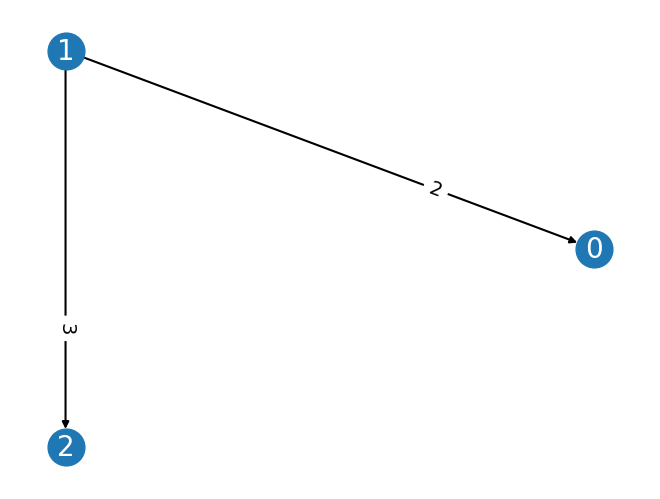

[[ 0 -1  0]
 [ 1  0  1]
 [ 0 -1  0]]
NOW SUPPORT
[[0 1 2]
 [2 0 3]
 [2 2 0]]
sc_ws [1]
sc_ws_support [0, 1]
sc fw [1]
+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 0 | 0 | 2 | 1 | 2 |
|   |   | 1 | 2 |   |
|   |   |   |   |   |
+---+---+---+---+---+


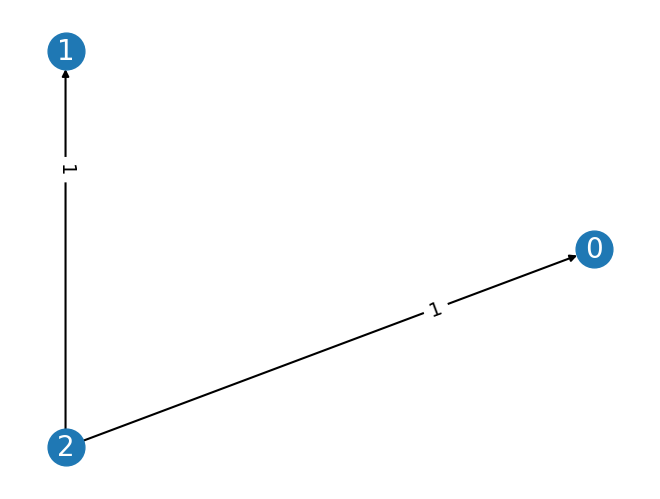

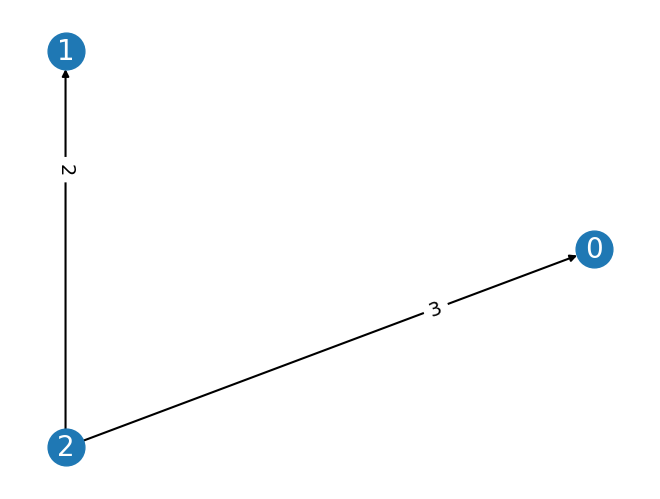

[[ 0  0 -1]
 [ 0  0 -1]
 [ 1  1  0]]
NOW SUPPORT
[[0 2 2]
 [2 0 1]
 [3 2 0]]
sc_ws [2]
sc_ws_support [1, 2]
sc fw [2]


In [7]:
for t in range(1000): 
    
    prof = generate_truncated_profile(3, 5)
    sc_ws = split_cycle2(prof) 
    sc_ws_support = split_cycle2(prof, strength_function=prof.support)
    cw = prof.condorcet_winner()
    if cw is not None and sc_ws != sc_ws_support:

        prof.display()
        prof.display_margin_graph()
        prof.display_support_graph()

        strength_matrix, cand_to_cindex = prof.strength_matrix()
        print(strength_matrix)
        strength_matrix_support, cand_to_cindex = prof.strength_matrix(strength_function=prof.support)
        print("NOW SUPPORT")
        print(strength_matrix_support)

        print("sc_ws", sc_ws)
        print("sc_ws_support", sc_ws_support)
        print("sc fw", split_cycle_Floyd_Warshall(prof))

[(0, 1, (4, 3)), (1, 2, (5, 2)), (2, 0, (6, 1))]


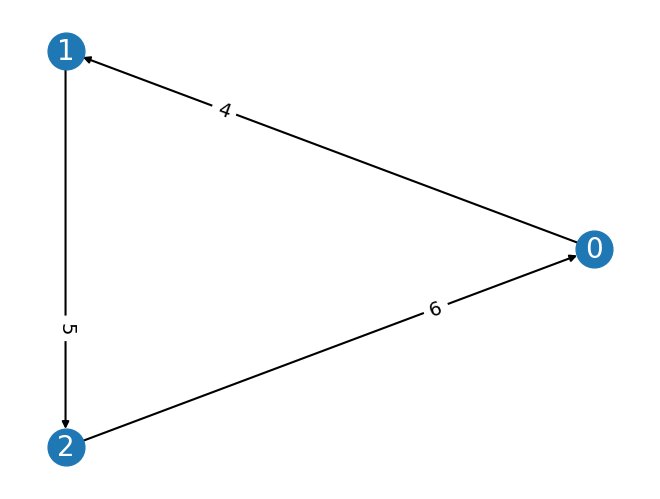

In [2]:
sg = SupportGraph(
        [0, 1, 2], 
        [(0, 1, (4, 3)), (1, 2, (5, 2)), (2, 0, (6, 1))]
    )

print(sg) 
print(sg.edges)
sg.display()

In [3]:
prof = ProfileWithTies([{0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9, 9:10, 10:11, 11:12}])

prof.write("test.csv", file_format="csv", csv_format="rank_columns")

prof2 = ProfileWithTies.read("test.csv", file_format="csv", csv_format="rank_columns")

prof2.display()

Election written to test.csv.
+----+
| 1  |
+----+
| 0  |
| 1  |
| 2  |
| 3  |
| 4  |
| 5  |
| 6  |
| 7  |
| 8  |
| 9  |
| 10 |
| 11 |
+----+


In [4]:
prof = ProfileWithTies(
        [
            {0:1, 1:2},
            {1:1, 2:2, 0:3},
            {2:1, 0:1}
        ], 
        [2, 3, 1])
write_csv(prof, str("prof"))


Election written to prof.csv.


'prof.csv'

In [5]:

r = [0, 1, 2]
indiff_list = [(c,) for c in r]
print(indiff_list)
c=10
print(f"{c}:{'>'.join(['='.join([str(c) for c in cs]) for cs in indiff_list])}")

[(0,), (1,), (2,)]
10:0>1>2


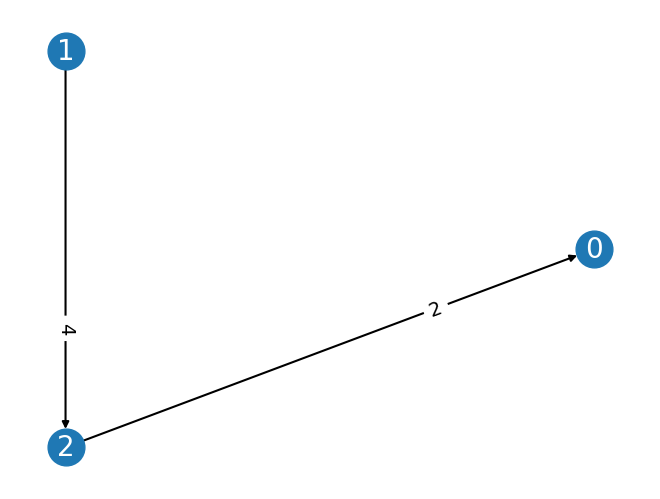

In [6]:
prof=Profile([[0, 1, 2], [1, 2, 0], [2, 0, 1]], [2, 3, 1])
prof.display_margin_graph()

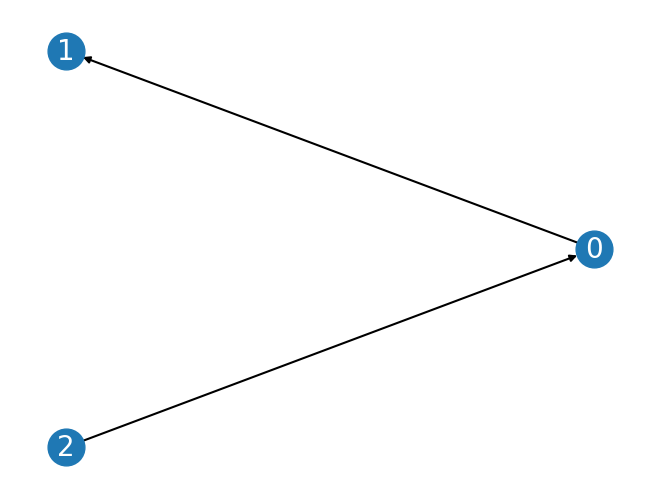

In [7]:
mg1 = MajorityGraph([0, 1], [(0, 1)])
mg2 = MajorityGraph([0, 2], [(2, 0)])
mg = mg1 + mg2
mg.display()

In [8]:
prof = ProfileWithTies([
        {0:1, 1:1, 2:2}, 
        {0:1, 1:1, 2:1}, 
        {0:1, 1:3, 2:2}],
        rcounts=[2, 1, 1])

prof.display()

plurality.display(prof)

+-----+-------+---+
|  2  |   1   | 1 |
+-----+-------+---+
| 0 1 | 0 1 2 | 0 |
|  2  |       | 2 |
|     |       | 1 |
+-----+-------+---+
Error: Cannot find the plurality scores unless all voters rank a unique candidate in first place.


AssertionError: Cannot calculate plurality scores.

In [9]:
prof.display()
prof.write("t", file_format='abif')

prof2 = ProfileWithTies.from_abif("t.abif", cand_type=int)
prof2.display()
print(prof2.candidates)

for r in prof2.rankings: 
    print(r)

prof == prof2

+-----+-------+---+
|  2  |   1   | 1 |
+-----+-------+---+
| 0 1 | 0 1 2 | 0 |
|  2  |       | 2 |
|     |       | 1 |
+-----+-------+---+
Election written to t.abif.


AttributeError: type object 'ProfileWithTies' has no attribute 'from_abif'

In [10]:
prof = Profile([
        [0, 1, 2], 
        [2, 1, 0]], 
        rcounts=[2, 1])

prof2 = Profile([
         [2, 1, 0],
         [0, 1, 2], 
       ], 
        rcounts=[1, 2])
prof3 = Profile([
         [2, 1, 0],
         [0, 1, 2], 
         [0, 1, 2], 
       ])

prof.display()
print(plurality_ranking(prof))

sorted([3, 1, 2], reverse=True)

print(prof == prof2)
print(prof == prof3)
print(prof2 == prof3)
#prof.rankings_counts == prof2.rankings_counts

+---+---+
| 2 | 1 |
+---+---+
| 0 | 2 |
| 1 | 1 |
| 2 | 0 |
+---+---+
0 2 1 
True
True
True


In [11]:
def has_strong_path_dfs(A, source, target, k):
    """Given a square matrix A, return True if there is a path from source to target in the associated directed graph     where each edge has a weight greater than or equal to k, and False otherwise."""
    
    n = A.shape[0] # assume A is a square matrix
    visited = np.zeros(n, dtype=bool)

    def dfs(node):
        if node == target:
            return True
        visited[node] = True
        for neighbor, weight in enumerate(A[node, :]):
            if weight >= k and not visited[neighbor]:
                if dfs(neighbor):
                    return True
        return False

    return dfs(source)


def has_strong_path_bfs(matrix, source, target, k):
    '''
    Given a square `matrix`, return `True` if there is a path from
    `source` to `target` in the associated directed graph, where each
    edge has a weight greater than or equal to `k`, and `False`
    otherwise.
    '''
    n = matrix.shape[0]  # `A` is square
    # keep track of visited nodes (initially all `False`)
    visited = np.zeros(n, dtype=bool)
    visited[source] = True  # do not revisit the `source` node

    def bfs(nodes):
        '''
        Breadth-first search implementation:
        Search starting from `nodes` in `matrix` until a path to
        `target` is found or until all nodes are searched. Since 
        Condorcet cycles are exceedingly rare in real elections and
        typically do not involve many candidates[1], a breadth-first
        search of the margins graph will be fastest to detect such a
        cycle.
        [1] (Gehrlein and Lepelley, "Voting Paradoxes and Group
            Coherence")
        '''
        queue = []  # nodes to search next cycle

        for node in nodes:
            # check for a direct path from `node` to `target`
            if matrix[node, target] >= k:
                return True

            # queue neighbors to check for a path to `target`
            visited[node] = True
            for neighbor, weight in enumerate(matrix[node, :]):
                if weight >= k and not visited[neighbor]:
                    queue.append(neighbor)

        return bfs(queue) if queue else False

    return bfs([source])


In [13]:
@vm(name="Split Cycle DFS")
def split_cycle_dfs(edata, curr_cands = None, strength_function = None):

    
    strength_matrix, cand_to_cindex = edata.strength_matrix(curr_cands = curr_cands, strength_function=strength_function)

    candidates = edata.candidates if curr_cands is None else curr_cands  

    strength_function = edata.margin if strength_function is None else strength_function 

    potential_winners = set(candidates)

    for a in candidates:
        for b in candidates:
            if strength_function(b,a) > 0 and not has_strong_path_dfs(strength_matrix, cand_to_cindex(a), cand_to_cindex(b), strength_function(b,a)):
                potential_winners.discard(a)
                break

    return sorted(potential_winners)


@vm(name="Split Cycle BFS")
def split_cycle_bfs(edata, curr_cands = None, strength_function = None):

    
    strength_matrix, cand_to_cindex = edata.strength_matrix(curr_cands = curr_cands, strength_function=strength_function)

    candidates = edata.candidates if curr_cands is None else curr_cands  

    strength_function = edata.margin if strength_function is None else strength_function 

    potential_winners = set(candidates)

    for a in candidates:
        for b in candidates:
            if strength_function(b,a) > 0 and not has_strong_path_bfs(strength_matrix, cand_to_cindex(a), cand_to_cindex(b), strength_function(b,a)):
                potential_winners.discard(a)
                break

    return sorted(potential_winners)



In [29]:

mgs = [generate_profile(10, 20).margin_graph() for _ in range(1000)]



In [30]:
%%time

[split_cycle_dfs(mg) for mg in mgs]


CPU times: user 60 ms, sys: 1.5 ms, total: 61.5 ms
Wall time: 61.1 ms


[[8],
 [7],
 [0, 6, 7, 8, 9],
 [1, 2],
 [0],
 [0],
 [4],
 [3],
 [0, 4],
 [2, 5],
 [7],
 [7],
 [3],
 [2],
 [2],
 [2],
 [1, 8],
 [2, 5],
 [5],
 [3, 7, 8, 9],
 [0, 1, 9],
 [2, 7],
 [7],
 [5, 7],
 [1],
 [4, 6, 7],
 [0, 2],
 [8],
 [2],
 [2, 7],
 [7],
 [4],
 [4, 5, 8],
 [3, 6],
 [4, 6, 7],
 [1, 6],
 [4, 5, 6, 7, 8],
 [0, 3],
 [5],
 [8],
 [8],
 [0, 2, 8],
 [0, 3],
 [1],
 [7],
 [9],
 [3],
 [5],
 [0, 3, 6],
 [5],
 [0],
 [2],
 [0, 4],
 [0],
 [0],
 [4],
 [6, 9],
 [4, 8],
 [3, 6],
 [6],
 [6, 7],
 [6, 9],
 [3],
 [6],
 [3, 6, 7, 8],
 [7],
 [0, 1, 3],
 [0, 3],
 [4, 8],
 [7],
 [7],
 [5, 8],
 [6],
 [5],
 [9],
 [9],
 [4],
 [8],
 [2],
 [0, 3, 4],
 [3],
 [8],
 [3, 4, 9],
 [4, 6, 7, 8],
 [3, 7],
 [1, 6],
 [4],
 [2],
 [1],
 [2],
 [7, 9],
 [6, 9],
 [4],
 [7],
 [9],
 [2, 3],
 [0],
 [1],
 [2, 7, 9],
 [9],
 [1, 3],
 [3, 6],
 [0, 1, 5],
 [2, 5],
 [0, 3, 7, 8],
 [4],
 [5],
 [0, 9],
 [1],
 [2],
 [2],
 [0, 4],
 [3, 7, 9],
 [2, 3],
 [6],
 [4],
 [8],
 [1, 7, 9],
 [3],
 [1, 8],
 [5, 9],
 [3],
 [7],
 [4],
 [7, 8],
 [3,

In [31]:
%%time
[split_cycle_bfs(mg) for mg in mgs]

CPU times: user 81 ms, sys: 2.84 ms, total: 83.8 ms
Wall time: 87.2 ms


[[8],
 [7],
 [0, 6, 7, 8, 9],
 [1, 2],
 [0],
 [0],
 [4],
 [3],
 [0, 4],
 [2, 5],
 [7],
 [7],
 [3],
 [2],
 [2],
 [2],
 [1, 8],
 [2, 5],
 [5],
 [3, 7, 8, 9],
 [0, 1, 9],
 [2, 7],
 [7],
 [5, 7],
 [1],
 [4, 6, 7],
 [0, 2],
 [8],
 [2],
 [2, 7],
 [7],
 [4],
 [4, 5, 8],
 [3, 6],
 [4, 6, 7],
 [1, 6],
 [4, 5, 6, 7, 8],
 [0, 3],
 [5],
 [8],
 [8],
 [0, 2, 8],
 [0, 3],
 [1],
 [7],
 [9],
 [3],
 [5],
 [0, 3, 6],
 [5],
 [0],
 [2],
 [0, 4],
 [0],
 [0],
 [4],
 [6, 9],
 [4, 8],
 [3, 6],
 [6],
 [6, 7],
 [6, 9],
 [3],
 [6],
 [3, 6, 7, 8],
 [7],
 [0, 1, 3],
 [0, 3],
 [4, 8],
 [7],
 [7],
 [5, 8],
 [6],
 [5],
 [9],
 [9],
 [4],
 [8],
 [2],
 [0, 3, 4],
 [3],
 [8],
 [3, 4, 9],
 [4, 6, 7, 8],
 [3, 7],
 [1, 6],
 [4],
 [2],
 [1],
 [2],
 [7, 9],
 [6, 9],
 [4],
 [7],
 [9],
 [2, 3],
 [0],
 [1],
 [2, 7, 9],
 [9],
 [1, 3],
 [3, 6],
 [0, 1, 5],
 [2, 5],
 [0, 3, 7, 8],
 [4],
 [5],
 [0, 9],
 [1],
 [2],
 [2],
 [0, 4],
 [3, 7, 9],
 [2, 3],
 [6],
 [4],
 [8],
 [1, 7, 9],
 [3],
 [1, 8],
 [5, 9],
 [3],
 [7],
 [4],
 [7, 8],
 [3,

In [8]:
prof = generate_profile(4, 3)
prof.display()

positive_negative_voting.display(prof)
print(score_ranking(prof, score = lambda nc, r: 1 if r == 1 else (-1 if r == nc else 0)))
print(score_ranking(prof, score = lambda nc, r: 1 if r == 1 else (-1 if r == nc else 0))[0])


+---+---+---+
| 1 | 1 | 1 |
+---+---+---+
| 2 | 1 | 2 |
| 1 | 2 | 1 |
| 0 | 0 | 3 |
| 3 | 3 | 0 |
+---+---+---+
Positive-Negative Voting winner is {2}
2 1 0 3 
2


In [21]:
sp = generate_spatial_profile(10, 5, 2)

up = sp.to_utility_profile()
u=up.utilities[0]
print(u)
u.ranking().display()
print(u.to_approval_ballot())
print(u.to_approval_ballot(prob_to_cont_approving=0.75, decay_rate=0.1))


U(0) = -5.13863254983446, U(1) = -3.0474384718160366, U(2) = -11.451603381536138, U(3) = -25.707866186555176, U(4) = -6.80719536050038, U(5) = -11.942319313080015, U(6) = -4.124575905559896, U(7) = -13.735056476444845, U(8) = -10.305442226791714, U(9) = -7.383180513512907
+---+
| 1 |
| 6 |
| 0 |
| 4 |
| 9 |
| 8 |
| 2 |
| 5 |
| 7 |
| 3 |
+---+
grade(0) = 1, grade(1) = 1, grade(2) = 0, grade(3) = 0, grade(4) = 1, grade(5) = 0, grade(6) = 1, grade(7) = 0, grade(8) = 0, grade(9) = 1
grade(0) = 1, grade(1) = 1, grade(2) = 0, grade(3) = 0, grade(4) = 0, grade(5) = 0, grade(6) = 1, grade(7) = 0, grade(8) = 0, grade(9) = 0


In [8]:
# numpy constants
np.exp(1)

2.718281828459045

In [3]:
num_cands = 3
num_voters = 5
num_dims = 2
num_trials = 10


for t in range(num_trials): 

    sp = generate_spatial_profile(num_cands, num_voters, num_dims)

    up = sp.to_utility_profile()
    up.display()
    approval_profile = up.to_approval_profile()
    print(approval_profile.approval_scores())

    approval.display(approval_profile)
    linear_profile = up.to_ranking_profile()
    #linear_profile.display()
    #plurality.display(linear_profile)

  Voter           0          1           2
-------  ----------  ---------  ----------
      1  -12.6028    -2.1544     -0.551926
      2   -0.893068  -9.34075   -10.6151
      3   -8.14037   -4.71895    -0.8146
      4  -14.2839    -1.71301    -2.51726
      5   -3.37234   -0.928658   -6.0275
{0: 2, 1: 3, 2: 3}
Approval winners are {1, 2}
  Voter          0           1          2
-------  ---------  ----------  ---------
      1  -1.4627     -3.11637    -9.23836
      2  -3.53456    -4.59473   -13.6041
      3  -1.53485    -0.175648  -18.9872
      4  -0.263538   -2.0872     -6.92993
      5  -9.9052    -15.004      -6.68236
{0: 5, 1: 4, 2: 1}
Approval winner is {0}
  Voter          0          1          2
-------  ---------  ---------  ---------
      1  -1.19541   -1.21983   -0.533409
      2  -2.18392   -4.24885   -0.950472
      3  -6.68989   -1.12608   -0.923681
      4  -0.885459  -8.03307   -4.7297
      5  -4.45453   -0.204068  -2.53374
{0: 2, 1: 2, 2: 3}
Approval winner is {2}

In [2]:
uprof = UtilityProfile([{0:1, 1:2, 2:3}, {0:0.5, 1:0.5, 2:0.5}, {0:0, 1:0, 2:0}])
uprof.display()




  Voter    0    1    2
-------  ---  ---  ---
      1  1    2    3
      2  0.5  0.5  0.5
      3  0    0    0


In [3]:
import pickle
pickle.dump(uprof, open("uprof.pkl", "wb"))

In [4]:
uprof = pickle.load(open("uprof.pkl", "rb"))
uprof.display()

  Voter    0    1    2
-------  ---  ---  ---
      1  1    2    3
      2  0.5  0.5  0.5
      3  0    0    0


In [3]:
import pref_voting
pref_voting.iterative_methods.tideman_alternative_smith

In [74]:
prof = generate_profile(4, 5)

prof.margin_matrix


[[0, -1, -1, 3], [1, 0, -1, 5], [1, 1, 0, 3], [-3, -5, -3, 0]]

In [75]:
prof = Profile([])
prof.candidates

[]

In [76]:
x='1_3_5_uniform_0_o.pickle'

'5_uniform' in x

True

In [46]:
# check of a list of lists are all unique
def all_unique(lst):
    return len(lst) == len(set(lst))

def all_single_winner(lst):
    return all([len(x) == 1 for x in lst])

In [65]:
num_trials = 100000
all_num_cands = [4, 5]
all_num_voters = [5, 6, 7, 9, 10, 11, 20, 21, 100, 101]

for num_cands in all_num_cands:
    print(num_cands)
    for num_voters in all_num_voters:
        print(num_voters)
        for t in tqdm(range(num_trials)):

            prof = generate_profile(num_cands, num_voters)
            
            bws = borda(prof)
            pws = plurality(prof)
            irvws = instant_runoff(prof)
            cws = coombs(prof)
            cw = prof.condorcet_winner()
            irv_exp = instant_runoff_with_explanation(prof)[1]
            coombs_exp = coombs_with_explanation(prof)[1]
            if cw is not None and all([len(xs) == 1 for xs in irv_exp]) and all([len(xs) == 1 for xs in coombs_exp]) and  all_unique([tuple(bws), tuple(pws), tuple(irvws), tuple(cws)]) and all_single_winner([irvws, bws, cws]):
                #print("ranking types ", len(prof.ranking_types))
                if len(prof.ranking_types) > 6:
                    continue
                prof.display()  
                print("Borda: ", bws)
                print("Plurality: ", pws)
                print("IRV: ", irvws)
                print(instant_runoff_with_explanation(prof))
                print("Coombs: ", cws)
                print(coombs_with_explanation(prof))

                print("Condorcet: ", cw)
                print(prof.description()) 
                print(prof.to_latex(cmap={0:"a", 1:"b", 2:"c", 3:"d", 4:"e"}))     
                #break


4
5


  0%|          | 0/100000 [00:00<?, ?it/s]

6


  0%|          | 0/100000 [00:00<?, ?it/s]

7


  0%|          | 0/100000 [00:00<?, ?it/s]

9


  0%|          | 0/100000 [00:00<?, ?it/s]

+---+---+---+---+---+---+---+
| 2 | 1 | 1 | 1 | 2 | 1 | 1 |
+---+---+---+---+---+---+---+
| 0 | 0 | 1 | 3 | 2 | 1 | 1 |
| 2 | 3 | 2 | 1 | 3 | 3 | 3 |
| 3 | 2 | 3 | 2 | 0 | 0 | 2 |
| 1 | 1 | 0 | 0 | 1 | 2 | 0 |
+---+---+---+---+---+---+---+
Borda:  [3]
Plurality:  [0, 1]
IRV:  [0]
([0], [[3], [2]])
Coombs:  [2]
([2], [[1], [0]])
Condorcet:  2
Profile([[0, 2, 3, 1], [0, 3, 2, 1], [1, 2, 3, 0], [3, 1, 2, 0], [2, 3, 0, 1], [1, 3, 0, 2], [1, 3, 2, 0]], rcounts=[2, 1, 1, 1, 2, 1, 1], cmap={0: '0', 1: '1', 2: '2', 3: '3'})
\begin{tabular}{ccccccc}
$2$ & $1$ & $1$ & $1$ & $2$ & $1$ & $1$\\\hline 
$a$ & $a$ & $b$ & $d$ & $c$ & $b$ & $b$\\ 
$c$ & $d$ & $c$ & $b$ & $d$ & $d$ & $d$\\ 
$d$ & $c$ & $d$ & $c$ & $a$ & $a$ & $c$\\ 
$b$ & $b$ & $a$ & $a$ & $b$ & $c$ & $a$
\end{tabular}
+---+---+---+---+---+---+
| 2 | 2 | 2 | 1 | 1 | 1 |
+---+---+---+---+---+---+
| 0 | 3 | 2 | 1 | 3 | 2 |
| 1 | 0 | 1 | 3 | 1 | 0 |
| 3 | 1 | 0 | 0 | 2 | 1 |
| 2 | 2 | 3 | 2 | 0 | 3 |
+---+---+---+---+---+---+
Borda:  [1]
P

  0%|          | 0/100000 [00:00<?, ?it/s]

11


  0%|          | 0/100000 [00:00<?, ?it/s]

+---+---+---+---+---+---+---+
| 3 | 3 | 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+
| 2 | 0 | 3 | 3 | 1 | 3 | 1 |
| 1 | 1 | 0 | 0 | 2 | 2 | 3 |
| 0 | 3 | 1 | 2 | 3 | 0 | 0 |
| 3 | 2 | 2 | 1 | 0 | 1 | 2 |
+---+---+---+---+---+---+---+
Borda:  [1]
Plurality:  [0, 2, 3]
IRV:  [3]
([3], [[1], [0]])
Coombs:  [0]
([0], [[2], [3]])
Condorcet:  0
Profile([[2, 1, 0, 3], [0, 1, 3, 2], [3, 0, 1, 2], [3, 0, 2, 1], [1, 2, 3, 0], [3, 2, 0, 1], [1, 3, 0, 2]], rcounts=[3, 3, 1, 1, 1, 1, 1], cmap={0: '0', 1: '1', 2: '2', 3: '3'})
\begin{tabular}{ccccccc}
$3$ & $3$ & $1$ & $1$ & $1$ & $1$ & $1$\\\hline 
$c$ & $a$ & $d$ & $d$ & $b$ & $d$ & $b$\\ 
$b$ & $b$ & $a$ & $a$ & $c$ & $c$ & $d$\\ 
$a$ & $d$ & $b$ & $c$ & $d$ & $a$ & $a$\\ 
$d$ & $c$ & $c$ & $b$ & $a$ & $b$ & $c$
\end{tabular}
+---+---+---+---+---+---+---+
| 3 | 2 | 1 | 2 | 1 | 1 | 1 |
+---+---+---+---+---+---+---+
| 1 | 0 | 3 | 2 | 2 | 0 | 3 |
| 3 | 3 | 2 | 1 | 1 | 2 | 0 |
| 2 | 1 | 0 | 3 | 0 | 3 | 1 |
| 0 | 2 | 1 | 0 | 3 | 1 | 2 |
+---+---

  0%|          | 0/100000 [00:00<?, ?it/s]

21


  0%|          | 0/100000 [00:00<?, ?it/s]

100


  0%|          | 0/100000 [00:00<?, ?it/s]

101


  0%|          | 0/100000 [00:00<?, ?it/s]

5
5


  0%|          | 0/100000 [00:00<?, ?it/s]

6


  0%|          | 0/100000 [00:00<?, ?it/s]

7


  0%|          | 0/100000 [00:00<?, ?it/s]

9


  0%|          | 0/100000 [00:00<?, ?it/s]

10


  0%|          | 0/100000 [00:00<?, ?it/s]

11


  0%|          | 0/100000 [00:00<?, ?it/s]

20


  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

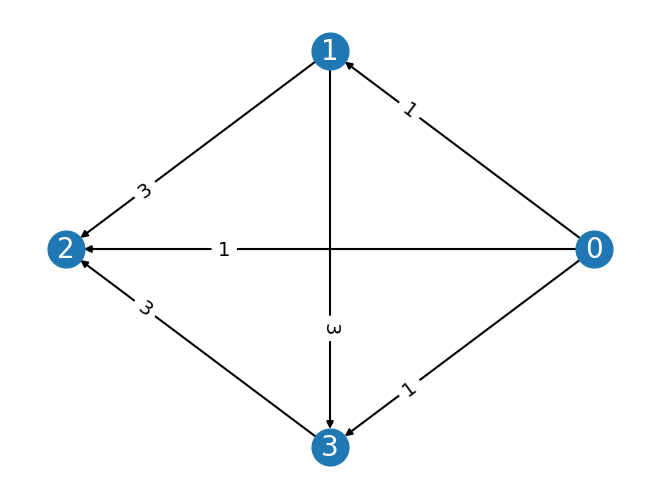


\begin{tikzpicture}
\node[circle,draw,minimum width=0.25in] at (0,0)      (a) {$a$}; 
\node[circle,draw,minimum width=0.25in] at (3,0)      (b) {$b$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,1.5)  (c) {$c$}; 
\node[circle,draw,minimum width=0.25in] at (1.5,-1.5) (d) {$d$};
\path[->,draw,thick] (a) to[pos=.7] node[fill=white] {$1$} (b);
\path[->,draw,thick] (a) to node[fill=white] {$1$} (c);
\path[->,draw,thick] (a) to node[fill=white] {$1$} (d);
\path[->,draw,thick] (b) to node[fill=white] {$3$} (c);
\path[->,draw,thick] (b) to node[fill=white] {$3$} (d);
\path[->,draw,thick] (d) to[pos=.7]  node[fill=white] {$3$} (c);
\end{tikzpicture}


In [69]:
prof = Profile([[0, 1, 3, 2], [3, 0, 1, 2], [2, 1, 0, 3], [1, 3, 0, 2], [3, 1, 2, 0], [2, 0, 1, 3]], rcounts=[2, 2, 2, 1, 1, 1], cmap={0: '0', 1: '1', 2: '2', 3: '3'})

prof.display_margin_graph()

mg = prof.margin_graph()
print(mg.to_latex(cmap={0:"a", 1:"b", 2:"c", 3:"d", 4:"e"}))

In [14]:
print(type(sorted(set([1, 3, 1, 2]))))

<class 'list'>


In [12]:
[1, 2, 3] == list(range(1, 4))

True

In [16]:
r = Ranking({0:1, 1:3, 3:3})

r.display()

+-----+
|  0  |
| 1 3 |
+-----+


In [8]:
r = Ranking({0:1, 1:-1, 3:0})
print(r[0])
print(r)

prof = create_election([r], use)
prof.display()

1
1 3 0 
+---+
| 1 |
+---+
| 0 |
| 1 |
| 2 |
+---+


In [22]:
print(pref_voting.monotonicity_axioms.find_all_weak_positive_responsiveness_violations)

<function find_all_weak_positive_responsiveness_violations at 0x29fe25580>


In [34]:
r1 = Ranking({0:-10001, 1:2, 3:3})
r2 = Ranking({0:2, 1:3, 3:4})

print(r1 == r2)

r1.display()
print(r1.ranks)

r1.normalize_ranks()
print(r1.ranks)
print(f"{r1}")

True
+---+
| 0 |
| 1 |
| 3 |
+---+
[-10001, 2, 3]
[1, 2, 3]
0 1 3 


In [35]:
r = Ranking({0:5, 1:10, 2:10, 3:20})
r.display()


print(r[0])
print(r[-1])
print(r[-2])

+-----+
|  0  |
| 1 2 |
|  3  |
+-----+
0
3
[1, 2]


In [38]:
using_extended_strict_preferences = False
if using_extended_strict_preferences: 
    print("hello")


In [41]:
prof = Profile([])

plurality.display(prof)

ValueError: max() arg is an empty sequence

In [5]:
prof = Profile([[0, 1, 2], [0, 1, 2]], rcounts=[2, 1])
print(prof._rankings)
print(prof.rankings)
print(prof.ranking_types)
print(prof.rankings_counts)

prof2 = prof.anonymize()
print(prof2._rankings)
print(prof2.rankings)
print(prof2.ranking_types)
print(prof2.rankings_counts)


[[0 1 2]
 [0 1 2]]
[(0, 1, 2), (0, 1, 2), (0, 1, 2)]
[(0, 1, 2)]
(array([[0, 1, 2],
       [0, 1, 2]]), array([2, 1]))
[[0 1 2]]
[(0, 1, 2), (0, 1, 2), (0, 1, 2)]
[(0, 1, 2)]
(array([[0, 1, 2]]), array([3]))


In [7]:
prof = ProfileWithTies([{0:1, 1:2}, {0:1, 1:2}], rcounts=[2, 1])

print(prof._rankings)

print(prof.rankings)
print(prof.ranking_types)
print(prof.rankings_counts)

prof.display()
prof2 = prof.anonymize()
prof2.display()

[<pref_voting.rankings.Ranking object at 0x2995bc790>, <pref_voting.rankings.Ranking object at 0x29ff41610>]
[<pref_voting.rankings.Ranking object at 0x2995bc790>, <pref_voting.rankings.Ranking object at 0x2995bc790>, <pref_voting.rankings.Ranking object at 0x29ff41610>]
([<pref_voting.rankings.Ranking object at 0x2995bc790>, <pref_voting.rankings.Ranking object at 0x29ff41610>], [2, 1])
+---+---+
| 2 | 1 |
+---+---+
| 0 | 0 |
| 1 | 1 |
+---+---+
+---+
| 3 |
+---+
| 0 |
| 1 |
+---+


+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 2 | 1 | 1 | 0 |
| 1 | 0 | 2 | 2 |
| 0 | 2 | 0 | 1 |
+---+---+---+---+


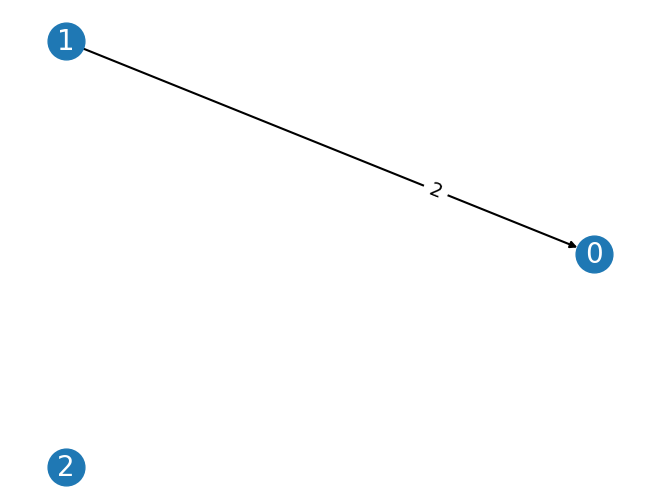

+---+---+
| 1 | 1 |
+---+---+
| 1 | 2 |
| 0 | 1 |
| 2 | 0 |
+---+---+


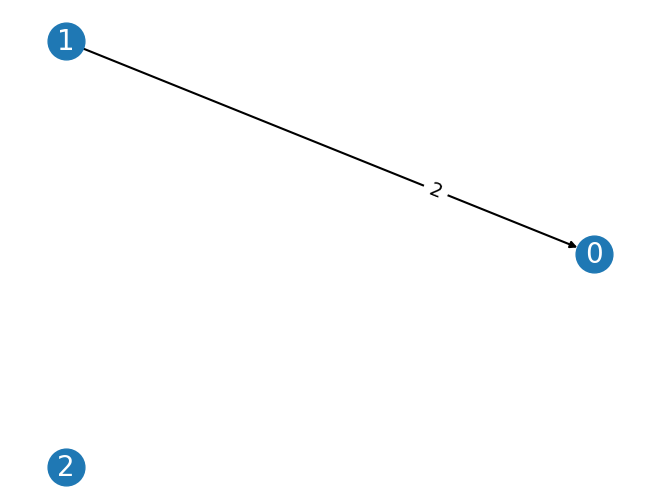

In [6]:
prof = generate_profile(3, 4)
prof.display()
mg = prof.margin_graph()

mg.display()

new_prof = mg.minimal_profile()

new_prof.display()
new_prof.margin_graph().display()   

In [7]:
print(len(voting_methods))

skip_vms = [anti_plurality, scoring_rule, instant_runoff, instant_runoff_tb, hare, ranked_choice, benham, coombs, coombs_tb, coombs_put, benham_tb, baldwin, baldwin_tb, baldwin_put, strict_nanson, weak_nanson, ranked_pairs_zt, condorcet_irv, smith_irv, kemeny_young, bucklin, simplified_bucklin, weighted_bucklin]
prof = generate_truncated_profile(4, 15)
for vm in voting_methods: 
    if vm in skip_vms: continue
    print(vm.name)
    vm.display(prof)

73
Plurality
Plurality winner is {2}
Borda
Borda winner is {2}
Borda
Borda winner is {2}
Instant Runoff PUT
Instant Runoff PUT winner is {2}
Bottom-Two-Runoff Instant Runoff
Bottom-Two-Runoff Instant Runoff winner is {2}
Bottom-Two-Runoff Instant Runoff PUT
Bottom-Two-Runoff Instant Runoff PUT winner is {2}
Benham PUT
Benham PUT winner is {2}
PluralityWRunoff PUT
PluralityWRunoff PUT winner is {2}
Iterated Removal Condorcet Loser
Iterated Removal Condorcet Loser winners are {0, 1, 2, 3}
Raynaud
Raynaud winner is {2}
Tideman Alternative Top Cycle
Tideman Alternative Top Cycle winner is {2}
Tideman Alternative Top Cycle PUT
Tideman Alternative Top Cycle PUT winner is {2}
Tideman Alternative GOCHA
Tideman Alternative GOCHA winner is {2}
Tideman Alternative GOCHA PUT
Tideman Alternative GOCHA PUT winner is {2}
Knockout Voting
Knockout Voting winner is {2}
Condorcet
Condorcet winner is {2}
Copeland
Copeland winner is {2}
Llull
Llull winner is {2}
Uncovered Set
Uncovered Set winner is {2}
Un

AttributeError: 'function' object has no attribute 'name'

In [ ]:
prof = generate_profile(3, 10)
prof.display()
print(prof.to_profile_with_ties())
print(prof.plurality_scores())

prof = ProfileWithTies([{0:1, 1:2},  {0:1}, {}, {},{2:1}, {0:1}], candidates=[0,1,2,3])
prof.display()
print(prof.borda_scores())
print(knockout(prof))

In [ ]:
for t in range(1000): 
    prof = generate_profile(4, 11)
    prof_w_t = prof.to_profile_with_ties()
    new_prof = ProfileWithTies([r.rmap for r in prof_w_t.rankings] + [{0:1}]*2, candidates=prof_w_t.candidates)
    new_prof.use_extended_strict_preference()
    baldwin.display(prof)
    baldwin.display(prof_w_t) 
    baldwin.display(new_prof)

In [ ]:
%%time 

uprofs = pickle.load(open('test_uprofs/evaluation_util_profs_1_6_11_uniform.pkl', 'rb'))

print(len(uprofs))

In [ ]:
%%time 

pickle.dump(uprofs, open('test_uprofs/evaluation_util_profs_1_6_11_uniform.pkl', 'wb'))


In [ ]:
%%time 

write_utility_profiles_to_json(uprofs, 'test_uprofs/evaluation_util_profs_1_6_11_uniform.json')


In [ ]:
%%time 

uprofs = read_utility_profiles_from_json('test_uprofs/evaluation_util_profs_1_6_11_uniform.json')

print(len(uprofs))

In [ ]:
uprof = generate_utility_profile_uniform(4, 5)
uprof.display()
for u in uprof.utilities: 
    print(u.as_dict())

print(uprof.as_dict())

# save dict to json file


with open('uprof.json', 'w') as f:
    json.dump(uprof.as_dict(), f)


In [ ]:
with open('uprof.json', 'r') as f:
    uprof_json = json.load(f)

    uprof = UtilityProfile.from_json(uprof_json)
    uprof.display()

    for u in uprof.utilities:
        for c in uprof.domain:
            print(u(c))
        print(u.as_dict())

In [ ]:
def test(i): 
    #np.random.seed(0)
    return np.random.random()

pool = Pool(4)

xs = pool.map(test, range(8))

In [ ]:
print(xs)

In [ ]:
print(len(xs) == len(list(set(xs))))

In [ ]:
a=0
b=1
c=2
d=3
mg = MarginGraph(
    [a,b,c,d],
    [
        (a,d,1),
        (a,c,9),
        (b,d,3),
        (b,a,11),
        (c,b,7),
        (d,c,5)
    ],
    cmap={a:"a",b:"b", c:'c', d:'d'}
)
mg.display()
copeland.display(mg)
minimax.display(mg)
beat_path.display(mg)
ranked_pairs.display(mg)
split_cycle.display(mg)

In [ ]:
prof = Profile(
    [
        [a,b,c,d],
        [b,c,d,a],
        [a,b,c,d],
        [a,b,d,c]

    ],
    cmap={a:"a",b:"b", c:'c', d:'d'}
)
prof.display()
prof.display_margin_graph()

In [ ]:
prof = Profile(
    [
        [a,b,c,d],
        [b,c,d,a],
        [c,d,a,b],
        [d,a,b,c]

    ],
    cmap={a:"a",b:"b", c:'c', d:'d'}
)
prof.display()
prof.display_margin_graph()

In [ ]:
prof = Profile(
    [
        [b, a,d , c],
        [d, b, a, c],
        [a, c, b, d],
        [d, c, b, a], 
        [d, c, b, a]

    ],
    rcounts=[2, 1, 3, 2, 1],
    cmap={a:"a",b:"b", c:'c', d:'d'}
)
prof.display()
prof.display_margin_graph()
mg = prof.margin_graph()

mg.display_with_defeat(beat_path_defeat(mg))

In [ ]:
prof = Profile(
    [
        [b, a,d , c],
        [d, b, a, c],
        [a, c, b, d],
        [d, c, b, a], 
        [d, b, c, a]

    ],
    rcounts=[2, 1, 3, 2, 1],
    cmap={a:"a",b:"b", c:'c', d:'d'}
)
prof.display()
prof.display_margin_graph()
mg = prof.margin_graph()

mg.display_with_defeat(beat_path_defeat(mg))

In [ ]:
e=4
prof = Profile(
    [
        [e, c, b, a, d],
        [c, b, a, d, e],
        [a, d, b, e, c]
    ],
         

    rcounts=[2, 1, 1],
    cmap={a:"a",b:"b", c:'c', d:'d',e:'e'}
)
prof.display()
maj_graph = prof.majority_graph()
maj_graph.display()
copeland.display(prof)

In [ ]:
e=4
prof = Profile(
    [
        [e, c, b, a, d],
        [c, b, a, d, e],
        [a, d, b, e, c],
        [c, e, d, b, a]
    ],
         

    rcounts=[2, 1, 1, 1],
    cmap={a:"a",b:"b", c:'c', d:'d',e:'e'}
)
prof.display()
maj_graph = prof.majority_graph()
maj_graph.display()
copeland.display(prof)

In [ ]:
e=4
prof = Profile(
    [
        [e, c, b, a, d],
        [c, b, a, d, e],
        [a, d, b, e, c],
        [c, e, d, b, a]
    ],
         

    rcounts=[2, 1, 1, 1],
    cmap={a:"a",b:"b", c:'c', d:'d',e:'e'}
)
prof.display()
maj_graph = prof.majority_graph()
maj_graph.display()
copeland.display(prof)

In [ ]:
m = _Mapping({0:1, 1:2}, val_map = {1:"A", 2:"B"})

print(m)

pickle.dump(m, open("mapping.p", "wb"))

In [ ]:
for i in range(100):
    print(np.random.choice([0, 1, 2], size=10))

In [ ]:
print(10)

In [ ]:

cand_cov = np.array([[0.5, 0.0], [0.0, 0.5]])
voter_cov  = np.array([[0.5, 0.0], [0.0, 0.5]])
sprof = generate_spatial_profile_polarized_cands_randomly_polarized_voters(
    [
        (np.array([0.0, 0.0]), cand_cov, 2), 
        (np.array([1.0, 1.0]), cand_cov, 2), 
        (np.array([-1.0, -1.0]), cand_cov, 2)], 
    1000,
    [
        (np.array([-1.0, -1.0]), voter_cov, 0.0), 
        (np.array([1.0, 1.0]), voter_cov, 0.0), 
        (np.array([0.0, 0.0]), voter_cov, 1.0)]
)

sprof.view()

In [ ]:
prof = Profile([[0,1], [0,1]])
prof.display()
plurality_with_runoff_put.display(prof)

In [ ]:
cond_eff_df = condorcet_efficiency_data([bracket_voting], num_trials = 100, numbers_of_candidates=[4, 5], numbers_of_voters=[1001], probmods = ["Spatial"], use_parallel=True)

cond_eff_df

In [ ]:
prof = generate_profile(3, 4, "Spatial", (3, quadratic_utility))

prof.display()

In [ ]:
data_for_df = {
    "probmod_param": [(2, None), (3, quadratic_utility)]
}

df = pd.DataFrame(data_for_df)

df

In [ ]:
prof = generate_profile(3, 10)

prof.plurality_scores([0])

In [ ]:
prof = generate_truncated_profile(4, 5)
prof.display()

print([r for r in prof.rankings_as_dicts_counts])

In [ ]:
prof = generate_profile(3, 5, probmod="MALLOWS", probmod_param=0.8)
prof.display()

In [ ]:
def generate_utility_profile_normal(num_candidates, num_voters, std = 0.1, normalize = None, num_profiles = 1):
    mean_utilities = {c: np.random.uniform(0, 1) for c in range(num_candidates)}
    print(mean_utilities)
    cand_utils = {c: np.random.normal(mean_utilities[c], std, size=(num_profiles, num_voters)) for c in range(num_candidates)} 
    
    print(cand_utils)
    if normalize == "range": 
        uprofs = [UtilityProfile([{c: cand_utils[c][pidx][vidx] 
                                   for c in range(num_candidates)} 
                                   for vidx in range(num_voters)]).normalize_by_range() 
                                   for pidx in range(num_profiles)]
    elif normalize == "score":
        uprofs = [UtilityProfile([{c: cand_utils[c][pidx][vidx] 
                                   for c in range(num_candidates)} 
                                   for vidx in range(num_voters)]).normalize_by_standard_score() 
                                   for pidx in range(num_profiles)]
    else: # do not normalize
        uprofs = [UtilityProfile([{c: cand_utils[c][pidx][vidx] 
                                   for c in range(num_candidates)} 
                                   for vidx in range(num_voters)]) 
                                   for pidx in range(num_profiles)]


    return uprofs if num_profiles > 1 else uprofs[0]


In [ ]:
uprofs = generate_utility_profile_normal(4, 5, num_profiles = 2)

for uprof in uprofs: 
    uprof.display()

In [ ]:
def generate_utility_profile_uniform2(num_candidates, num_voters, num_profiles = 1):
    """
    Generate a utility profile where each voter assigns a random number between 0 and 1 to each candidate.

    Args:   
        num_candidates (int): The number of candidates.
        num_voters (int): The number of voters.
    
    Returns:
        UtilityProfile: A utility profile.

    """

    cand_utils = np.random.uniform(size=(num_profiles, num_voters, num_candidates))

    uprofs = [UtilityProfile([{c: cand_utils[pidx][v][c] 
                               for c in range(num_candidates)} 
                               for v in range(num_voters)]) 
                               for pidx in range(num_profiles)]
    
    return uprofs if num_profiles > 1 else uprofs[0]


In [ ]:
%timeit np.random.uniform(size=(1000, 100, 10))

In [ ]:
%timeit [np.random.uniform(size=(1, 100, 10)) for _ in range(1000)]

In [ ]:
%timeit [generate_utility_profile_uniform2(10, 100) for _ in range(100)]

In [ ]:
%timeit generate_utility_profile_uniform2(10, 100, num_profiles = 100)

In [ ]:
uprofs = generate_utility_profile_uniform2(5, 4, num_profiles = 4)

for uprof in uprofs: 
    uprof.display()
    print()

In [ ]:
def np_norm(x: float32[:]):
    return np.linalg.norm(x)
 
@njit
def np_norm_jit(x: float32[:]):
    return np.linalg.norm(x)
 
@njit(float32(float32[:]), fastmath=True)
def np_norm_jit_full(x):
    return np.linalg.norm(x)

@njit
def linear_utility2(v_pos: float32[:], c_pos: float32[:]):
    """
    The utility of the voter for the candidate is negative of the difference in positions. 

    Args:   
        v_pos (numpy array): The position(s) of the voter.
        c_pos (numpy array): The position(s) of the candidate.  
    Returns:
        float: The utility of the candidate to the voter.
    """
    return -np.linalg.norm(v_pos - c_pos)


In [ ]:
%timeit linear_utility2(np.array([0.0, 1.0]), np.array([1.0, 1.0]))

In [ ]:
sprofs = generate_spatial_profile(5, 5, 3, num_profiles= 1000)


In [ ]:
%timeit [sprof.to_utility_profile(utility_function=linear_utility) for sprof in sprofs]

In [ ]:
%timeit [sprof.to_utility_profile(utility_function=linear_utility2) for sprof in sprofs]

In [ ]:
%timeit linear_utility(np.array([0.0, 1.0]), np.array([1.0, 1.0]))

In [ ]:
%timeit quadratic_utility(np.array([0, 1]), np.array([1, 1]))

In [ ]:
%timeit linear_utility(np.array([0, 1]), np.array([1, 1]))

In [ ]:
voter_mean = np.array([0,0])
voter_cov = np.eye(2)
num_voters = 3
num_profiles = 5
voter_sample1 = np.random.multivariate_normal(voter_mean, voter_cov, size=(num_profiles, num_voters))

voter_sample2 = np.random.multivariate_normal(voter_mean, voter_cov, size=(num_profiles, num_voters))

voter_sample3 = [list(voter_sample1[pidx]) + list(voter_sample2[pidx]) for pidx in range(num_profiles)]

for v in voter_sample3:
    print(v)
    print()


In [ ]:
def generate_spatial_profile_polarized2(cand_clusters, voter_clusters, num_profiles = 1):

    cand_samples = list()
    total_num_cands = 0
    for cand_cluster in cand_clusters:
        cand_mean, cand_cov, num_cands = cand_cluster
        total_num_cands += num_cands
        cluster_samples = np.random.multivariate_normal(cand_mean, cand_cov, 
                                                        size=(num_profiles,num_cands))
        if len(cand_samples) == 0:
            cand_samples = cluster_samples
        else:
            #cand_samples = [list(cand_samples[pidx]) + list(cluster_samples[pidx]) 
            #                for pidx in range(num_profiles)]
            cand_samples = np.concatenate([cand_samples, cluster_samples], axis=1)

    voter_samples = list()
    total_num_voters = 0
    for voter_cluster in voter_clusters:
        voter_mean, voter_cov, num_voters = voter_cluster
        total_num_voters += num_voters
        cluster_samples = np.random.multivariate_normal(voter_mean, voter_cov, 
                                                        size=(num_profiles,num_voters))
        if len(voter_samples) == 0:
            voter_samples = cluster_samples
        else:
            voter_samples = np.concatenate([voter_samples, cluster_samples], axis=1) 

    
    profs = [SpatialProfile({cidx: cand_samples[pidx][cidx]
                           for cidx in range(total_num_cands)},
                           {vidx: voter_samples[pidx][vidx]
                            for vidx in range(total_num_voters)}) 
                            for pidx in range(num_profiles)]
    
    return profs[0] if num_profiles == 1 else profs

In [ ]:
profs = generate_spatial_profile(5, 5, 3, num_profiles= 5)
for p in profs: 
    p.display()

In [ ]:
elections = np.concatenate([np.array([[[0,1], [0, 3]], [[2,1], [1, 3]]]), np.array([[[1,0], [1,1]], [[5,0], [1,5]]])], axis=1)

for e in elections: 
    print(e)
    print()

In [ ]:
cand_clusters = [((0,0), np.eye(2), 3), ((1,1), np.eye(2), 3)]
voter_clusters = [((0,0), np.eye(2), 3), ((1,1), np.eye(2), 3)]
prof = generate_spatial_profile_polarized(cand_clusters, voter_clusters)
prof2 = generate_spatial_profile_polarized2(cand_clusters, voter_clusters)
prof2.display()

In [ ]:
%timeit [generate_spatial_profile_polarized(cand_clusters, voter_clusters) for _ in range(1000)]

In [ ]:
%timeit generate_spatial_profile_polarized2(cand_clusters, voter_clusters, num_profiles = 1000)

In [ ]:
%timeit generate_spatial_profile_polarized2(cand_clusters, voter_clusters, num_profiles = 1000)

In [ ]:
generate_spatial_profile_polarized2([((0,0), np.eye(2), 3), ((1,1), np.eye(2), 3)], 
                                   [((0,0), np.eye(2), 3), ((1,1), np.eye(2), 3)])

In [ ]:
%timeit [np.random.multivariate_normal(voter_mean, voter_cov, size=num_voters) for t in range(100)]

In [ ]:
%timeit np.random.multivariate_normal(voter_mean, voter_cov, size=(100, num_voters))

In [ ]:
# Simple Stable Voting 
def _simple_stable_voting(edata, 
                          curr_cands, 
                          strength_function,
                          mem_sv_winners, 
                          sorted_matches):
    
    sv_winners = list()
        
    if len(curr_cands) == 1: 
        mem_sv_winners[tuple(curr_cands)] = curr_cands
        return curr_cands, mem_sv_winners
    
    margin_witnessing_win = -math.inf

    for a, b, s in sorted_matches:
        if s < margin_witnessing_win: 
            break
        if a not in sv_winners: 
            cands_minus_b = [c for c in curr_cands if c != b]
            cands_minus_b_key = tuple(sorted(cands_minus_b))
            if cands_minus_b_key not in mem_sv_winners.keys(): 
                ws, mem_sv_winners = _simple_stable_voting(edata, 
                                                           curr_cands = cands_minus_b,
                                                           strength_function = strength_function,
                                                           mem_sv_winners = mem_sv_winners, 
                                                           sorted_matches = [(a, c, s) for a, c, s in sorted_matches if c != b and a != b])
                mem_sv_winners[cands_minus_b_key] = ws
            else: 
                ws = mem_sv_winners[cands_minus_b_key]
            if a in ws:
                sv_winners.append(a)
                margin_witnessing_win = s

    return sv_winners, mem_sv_winners
    
@vm(name = "Simple Stable Voting")
def simple_stable_voting(edata, curr_cands = None, strength_function = None): 
   
    
    curr_cands = edata.candidates if curr_cands is None else curr_cands
    strength_function = edata.margin if strength_function is None else strength_function  

    matches = [(a, b, strength_function(a, b)) for a in curr_cands for b in curr_cands if a != b]
    sorted_matches = sorted(matches, reverse=True, key=lambda m_w_weight: m_w_weight[2])
    
    return sorted(_simple_stable_voting(edata, 
                                        curr_cands = curr_cands, 
                                        strength_function = strength_function,
                                        mem_sv_winners = {}, 
                                        sorted_matches = sorted_matches)[0])


In [ ]:
cov_m = generate_covariance_matrix(30)

In [ ]:
random_var = multivariate_normal(None, cov_m)

In [ ]:
print(random_var.rvs())

In [ ]:
%timeit [multivariate_normal(None, cov_m) for _ in range(100)]

In [ ]:
random.permutation(range(10))


In [ ]:
%timeit multivariate_normal(None, cov_m)

In [ ]:
%timeit [generate_edge_ordered_tournament_infinite_limit(30) for _ in range(100)]

In [ ]:
%timeit [generate_edge_ordered_tournament_infinite_limit(30, cov_matrix = cov_m) for _ in range(100)]

In [ ]:
random.uniform(0.001, 0.999)

In [ ]:
def find_best_response(uprof, vm):

    u0 = uprof.utilities[0]
    prof = uprof.to_ranking_profile().to_linear_profile()
    rankings = prof.rankings
    ws = vm(prof)
    eu_ws = np.average([u0(w) for w in ws])
    best_rankings = list()
    current_best_eu = eu_ws
    for new_ranking in permutations(prof.candidates):
        new_prof = Profile([new_ranking] + rankings[1:])
        new_ws = vm(new_prof)
        new_eu_ws = np.average([u0(w) for w in new_ws])
        if new_eu_ws > current_best_eu:
            current_best_eu = new_eu_ws
            best_rankings = [new_ranking]
        elif new_eu_ws == current_best_eu:
            best_rankings.append(new_ranking)
    return best_rankings


In [ ]:
uprof = generate_utility_profile_uniform(3, 4)

uprof.display()

prof = uprof.to_ranking_profile().to_linear_profile()
prof.display()
plurality.display(prof)
find_best_response(uprof, plurality)

In [ ]:
for t in range(1000): 
    prof = generate_profile(4, 5) 
    #prof.display()
    c_ws = copeland(prof)
    c_b_ws = copeland_borda(prof)
    c_gb_ws = copeland_global_borda(prof)
    if c_b_ws != c_gb_ws:
        prof.display()
        prof.display_margin_graph()
        print(prof.borda_scores())
        print("c_ws", c_ws)
        print("c_b_ws", c_b_ws)
        print("c_gb_ws", c_gb_ws)

In [ ]:
df = condorcet_efficiency_data([plurality, split_cycle],
    numbers_of_candidates=[3],
    numbers_of_voters=[4],
    probmods=["IC"],
    num_trials=10,
    use_parallel=True,
    num_cpus=5,
)

df

In [ ]:
sp = generate_spatial_profile_polarized(
    [(np.array([1,0]), generate_covariance(2, 0.5, 0), 3), 
    (np.array([-1,0]), generate_covariance(2, 0.5, 0), 3)],
    [
    (np.array([1,0]), generate_covariance(2, 0.5, 0), 10000),
    (np.array([-1,0]), generate_covariance(2, 0.5, 0), 10000)]
    
    )



sp.view()

In [ ]:
sp = generate_spatial_profile_polarized(
    [(np.array([1,1]), generate_covariance(2, 0.5, 0), 3), 
    (np.array([-1,-1]), generate_covariance(2, 0.5, 0), 3)],
    [
    (np.array([1,1]), generate_covariance(2, 0.5, 0), 10000),
    (np.array([-1,-1]), generate_covariance(2, 0.5, 0), 10000)]
    
    )

sp.view()

In [ ]:
x = np.random.random(100)
y = np.random.random(100)


print("np.average(x)* np.average(y)", np.average(x) * np.average(y))
print("np.average(x * y)", np.average(x * y))
print()

print("np.average(x) / np.average(y)", np.average(x) / np.average(y))
print("np.average(x/y)", np.average(x/y))
print()

print("np.average(x) + np.average(y)", np.average(x) + np.average(y))
print("np.average(x +  y)", np.average(x + y))
print()

print("np.average(x) - np.average(y)", np.average(x) - np.average(y))
print("np.average(x - y)", np.average(x - y))


In [ ]:
for t in tqdm(range(1000)): 

    prof = generate_profile(6, 500)

    cw = prof.condorcet_winner()
    woodall_ws = woodall(prof)

    river_ws = river_zt(prof)

    if cw is not None and [cw] != river_ws:
        print("ERROR")
        print("river: ", river_ws)
        print("cw: ", cw)
        prof.display_margin_graph()


In [ ]:
for t in tqdm(range(1000)): 

    prof = generate_profile(10, 1001)

    s_set = smith_set(prof)
    cw = prof.condorcet_winner()
    woodall_ws = woodall(prof)
    if (cw is not None and woodall_ws != [cw]) or any([w not in s_set for w in woodall_ws]): 
        print("ERROR")
        print("cw: ", cw)
        print("s_set: ", s_set)
        print("woodall_ws: ", woodall_ws)

In [ ]:
prof = generate_profile(3, 21)
prof.display_margin_graph()
copeland.display(prof)
print(c1_maximal_lottery(prof))
print(bipartisan(prof))
print(maximal_lottery(prof))
print(essential(prof))



In [ ]:
mg = MarginGraph(
    [0, 1,2 ],
    [(0, 1, 1), 
    (1, 2, 5), 
    (2, 0, 3)]
)
mg.display()

A = np.array(mg.margin_matrix)

# Create the game
game = nash.Game(A)
print(game)
# Find the Nash Equilibrium with Support Enumeration
equilibria = game.support_enumeration()
for eq in equilibria:
    print(eq)



In [ ]:


for t in range(1000): 

    prof = generate_profile(3, 5)
    if prof.condorcet_winner() is None:
        prof.display_margin_graph()

        print(prof.margin_graph().margin_matrix)
        # Define the payoff matrix for players
        # A and B should be square matrices where the dimension is equal to the number of actions
        A = np.array(prof.margin_matrix)
        B = -A  # For zero sum games, player 2's payoff matrix is the negative of player 1's

        # Create the game
        game = nash.Game(A)
        print(game)
        # Find the Nash Equilibrium with Support Enumeration
        equilibria = game.support_enumeration()
        for eq in equilibria:
            print(eq)

        break


In [ ]:
for t in tqdm(range(1000)): 
    prof = generate_spatial_profile(10, 1001, 2).to_utility_profile().to_ranking_profile().to_linear_profile()

    A = np.array(prof.margin_matrix)

    game = nash.Game(A)
    equilibria = list(game.vertex_enumeration())

    if len(equilibria) != 1: 
        prof.display_margin_graph()
        print(prof.margin_matrix)
        print(equilibria)



In [ ]:
prof = generate_profile(4, 4)

prof.display()
print(prof.borda_scores())


print(random_dictator(prof))
print(random_dictator.name)
print(pr_borda(prof))

In [ ]:
uprof = UtilityProfile([{0: u, 1: 20*u, 2: 30*u} for u in  [50, 60, 70, 80, 90, 100, 110]])

uprof.display()

uprof.normalize_by_range().display()

uprof.normalize_by_standard_score().display()

util_avg = uprof.avg_utility_function()

for x in uprof.domain: 
    print(x, util_avg(x))

In [ ]:
up = generate_spatial_profile(3, 3, 2).to_utility_profile()

up.display()
up.normalize_by_range().display()

up.normalize_by_standard_score().display()

In [ ]:
sp = generate_spatial_profile(5, 10, 2)

sp.view()

In [ ]:
sp = generate_spatial_profile(5, 15, 3)
sp.view()
sp.display()
sp_str = sp.write()

sp2 = SpatialProfile.from_string(sp_str)

sp2.view()
sp2.display()


In [ ]:
for t in range(100): 
    prof = generate_profile(4, 11)  
    print(split_cycle(prof)  ) 

In [ ]:

for t in range(1000):
    for vm in [split_cycle, 
               stable_voting, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               simple_stable_voting, 
               copeland,
               borda, 
               plurality, 
               plurality_with_runoff_put, 
               instant_runoff, 
               coombs, 
               minimax, 
               strict_nanson, 
               bucklin]: 

        prof = generate_profile(5, 11)

        vm.display(prof)
        
        prof = generate_profile(5, 10)

        vm.display(prof)

        ws_restricted = vm(prof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)

    print()




In [ ]:
for t in range(100):
    for vm in [split_cycle, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               plurality,
               stable_voting, 
               simple_stable_voting, 
               copeland,
               borda_for_profile_with_ties,
               instant_runoff_for_truncated_linear_orders
               ]: 

        prof = generate_truncated_profile(5, 11)

        vm.display(prof)
        prof = generate_truncated_profile(5, 10)

        vm.display(prof)

        ws_restricted = vm(prof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)


    print()


In [ ]:
for t in range(100):
    for vm in [split_cycle, 
               beat_path, 
               beat_path_Floyd_Warshall, 
               split_cycle_Floyd_Warshall, 
               stable_voting, 
               simple_stable_voting, 
               gocha,
               smith_set,
               copeland
               ]: 

        mg = generate_margin_graph(5)

        vm.display(mg)
        mg = generate_edge_ordered_tournament(4)
        vm.display(mg)

        mg = generate_edge_ordered_tournament_infinite_limit(5)
        vm.display(mg)


        ws_restricted = vm(mg, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)


    print()


In [ ]:
for t in range(100):
    for um in [sum_utilitarian,
                relative_utilitarian,
                maximin,
                lexicographic_maximin,
                nash_bargaining,
               ]: 

        uprof = generate_utility_profile_uniform(5, 10)
        print(um(uprof))

        uprof = generate_utility_profile_normal(6, 20)
        print(um(uprof))

        uprof = generate_spatial_utility_profile(5, 11)
        print(um(uprof))

    print()


In [ ]:
for t in range(100):
    for vm in [sum_utilitarian_ws,
                relative_utilitarian_ws,
                maximin_ws,
                lexicographic_maximin_ws,
                nash_ws,
               ]: 

        uprof = generate_utility_profile_uniform(5, 10)
        vm.display(uprof)

        uprof = generate_utility_profile_normal(6, 20)
        vm.display(uprof)

        uprof = generate_spatial_utility_profile(5, 11)
        vm.display(uprof)

        ws_restricted = vm(uprof, curr_cands = [0, 1, 2])
        if not all([w in [0, 1, 2] for w in ws_restricted]): 
            print("ERROR: ", vm.name, ws_restricted, " not an element of [0, 1, 2]")
            
            exit(1)

    print()
